#AIML Lab
###Methodology
speech input --> translate to english --> intent classification & slot tagging --> return text output --> convert to telugu speech

###Architecture
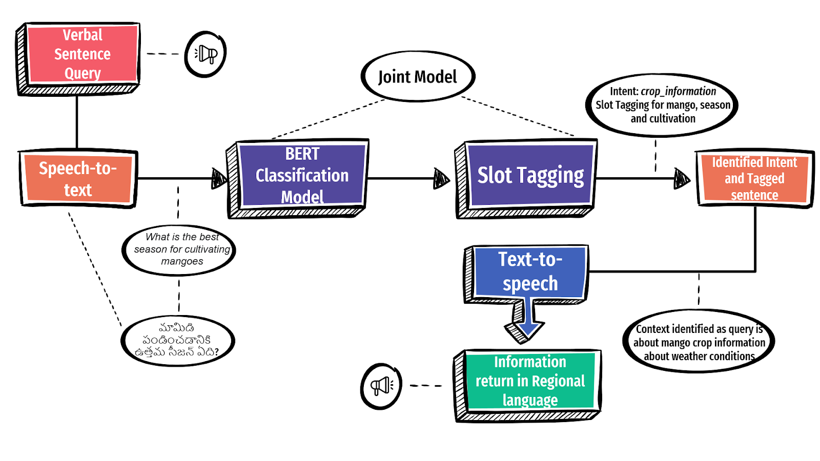

### Connect to Drive
Ease of Dataset Access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/repos/JointBERT

/content/drive/MyDrive/repos/JointBERT


### Installations

In [ ]:
% pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 748.8 MB 19 kB/s 
     |████████████████████████████████| 769 kB 65.3 MB/s 
     |████████████████████████████████| 3.0 MB 51.2 MB/s 
     |████████████████████████████████| 880 kB 64.2 MB/s 
     |████████████████████████████████| 1.3 MB 56.6 MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-py3-none-any.whl size=7435 sha256=0287316271938730bd17b635e3f6c3da7b1813454ea5e441cc172be2e7b799aa
  Stored in directory: /root/.cache/pip/wheels/dc/cc/62/a3b81f92d35a80e39eb9b2a9d8b31abac54c02b21b2d466edc
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=3f7c5c85c2854eec5183bddab825a26c09491e04c61f7f806434c6f46129e259
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built seqeval sacremoses
  Attempting uninstall: torch
    Found existin

In [ ]:
!pip install speechrecognition
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install ffmpeg-python
!pip install translate
!pip install gTTS
!pip install googletrans
!pip install google-search-results

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 1.2 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libasound2-dev is already the newest version (1.1.3-5ubuntu0.6).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 19 not upgraded.
Need to get 184 kB of archives.
After this operation, 891 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudiocpp0 amd64 19.6.0

### Importing Modules

In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import speech_recognition as sr
from translate import Translator
import scipy
from os import path
import pandas as pd
import numpy as np
import os.path
import requests 
import pandas as pd 
from bs4 import BeautifulSoup 
from googlesearch import search
import re
from gtts import gTTS
import os

### Taking Speech Input

In [ ]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

### Converting Speech to Text

In [ ]:
def speech_to_text(filename):
  AUDIO_FILE = "/content/drive/MyDrive/repos/JointBERT/" + filename

  r = sr.Recognizer()
  with sr.AudioFile(AUDIO_FILE) as source:
      audio = r.record(source)  # read the entire audio file
      try:
          text = r.recognize_google(audio, language = "te-TE")
          print(text)
          translator= Translator(from_lang="te-IN",to_lang="en")
          result = translator.translate(text)
          print("Did you say")
          print("Telugu: " + text)
          print("English: " + result)
          return result, text
      except Exception as e:
          print("Error: " + str(e))

### Web-Scraping

In [ ]:
from typing_extensions import final
def getdata(url): 
    r = requests.get(url)
    return r.text

def textScraping(link):
    count = 0
    htmldata = getdata(link) 
    soup = BeautifulSoup(htmldata, 'html.parser') 
    data =''
    t=""
    for data in soup.find_all("p"):
        t+=data.get_text()
    t = re.sub('[\n\t\r]', ' ', t)
    print(t)
    return t

def web_scraping(result, file):
  query = result
  strings=""
  finaltext=""
  for j in search(query,  lang = 'te', num=3, stop=3):
      print(j)
      strings=textScraping(j)
      list=strings.split('.')
      list=list[0:5]
      if(len(list)>3):
          for i in list:
              finaltext=finaltext+i+'.'  
          file.write(finaltext)
          print("Now its this-------------------------")
          print(finaltext)
      strings=''
      list=[]
  return finaltext

### Text to Speech

In [ ]:
from IPython.display import Audio
from IPython.display import display
def text_to_speech(finaltext):
  mytext = finaltext
  language = 'te'
  myobj = gTTS(text=mytext, lang=language, slow=False)
  myobj.save("query-answer.mp3")
  os.system("query-answer.mp3") 
  wn = Audio('query-answer.mp3', autoplay=True)
  display(wn)

def text_to_speech_testing(finaltext):
  mytext = finaltext
  language = 'te'
  myobj = gTTS(text=mytext, lang=language, slow=False)
  myobj.save("query-answer.mp3")
  os.system("query-answer.mp3") 
  wn = Audio('query-answer.mp3', autoplay=False)
  display(wn)

In [ ]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

from serpapi import GoogleSearch
def query_answer(query, file):
  params = {
    "engine": "google",
    "q": query,
    "api_key": "24de4b7497ef5bdf7a68940e900ba077e11fc2b55ac1deabcc2dcf5196631b26"
  }
  with HiddenPrints():
    search = GoogleSearch(params)
    results = search.get_dict()
    organic_results = results["organic_results"]
  
  ans=organic_results[0].get("snippet") 
  ans3=organic_results[1].get("snippet")
  ans2=ans.split('.')
  #if(type(ans3)!=None):
  ans4=ans3.split('.')
  ans=ans2[0]+". "+ans4[0]
  #else:
   #ans=ans2[0]

  translator= Translator(from_lang="en",to_lang="te-IN")
  result = translator.translate(ans)
  file = open("file.txt", "w") 
  file.write(result)
  return result


In [ ]:
def speech_output():

  # record audio from user into audio_user.wav
  print("Speak to record audio in Telugu")
  audio, sr = get_audio()
  scipy.io.wavfile.write('audio_user.wav', sr, audio)
  print("File saved")
  print("--------------------------------------------")

  # use of speech_recognition library to convert speech to text
  print("Speech to text conversion")
  filename = 'audio_user.wav'
  converted_english_text, converted_telugu_text = speech_to_text(filename)
  print("--------------------------------------------")

  # saving the converted text to txt file
  f = open("query.txt", 'w')
  converted_english_text = converted_english_text.replace("?","")
  f.write(converted_english_text)
  f.close()

  # intent classification and slot tagging using JointBERT trained model
  print("Intent Classification and Slot Tagging Prediction")
  ! python predict.py --input_file query.txt --output_file intent_slot.txt --model_dir agri_model_quads
  print("--------------------------------------------")

  print("Model output")
  f = open("intent_slot.txt", "r+")
  for line in f:
    print(line, end='')

  print("--------------------------------------------")

  # getting a customized answer to farmer's query
  print("Customised answer for query")
  file = open("Query-Answer.txt", "w+")
  #print(len(converted_telugu_text))
  text_answer = query_answer(converted_english_text, file)
  print(text_answer)
  text_to_speech(text_answer)

In [ ]:
speech_output()

Speak to record audio in Telugu


File saved
--------------------------------------------
Speech to text conversion


FileNotFoundError: ignored

#Testing on Multiple Inputs

In [ ]:
test_list=["when is the best time to grow potatoes",
"what is the price of tractors",
"what diseases do pigs get",
"what are the stages of irrigation",
"why too many fertilizers are bad for plants",
"what is the selling price of mangoes in India",
"is floriculture expensive",
"what is the use of plough",
"which pig gives the best pork",
"is black soil good for growing crops",
"what are the different types of fertilizers",
"does ginger grow well in summer"
]

print("\033[1m Intent Classification and Slot Tagging Prediction \033[0m")
! python predict.py --input_file query2.txt --output_file intent_slot2.txt --model_dir agri_model_quads
print("--------------------------------------------")
def testing():
  f = open("intent_slot2.txt", "r+")
  i=0
  for line in f:
    print("\033[1m Test Case \033[0m",i+1)
    print("Telugu Query:",test_list[i])
    translator= Translator(from_lang="en",to_lang="te-IN")
    result = translator.translate(test_list[i])
    print("English Translated Query:",result)
    print(line, end='')
    print("Customised answer for query:")
    file = open("Query-Answer2.txt", "w+")
    text_answer = query_answer(test_list[i], file)
    print(text_answer)
    translator= Translator(from_lang="te-IN",to_lang="en")
    result = translator.translate(text_answer)
    print(result)
    text_to_speech_testing(text_answer)
    i=i+1
    print("--------------------------------------------")

testing()
  
  

 Intent Classification and Slot Tagging Prediction 
08/13/2022 01:38:33 - INFO - transformers.configuration_utils -   loading configuration file agri_model_quads/config.json
08/13/2022 01:38:33 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "architectures": [
    "JointBERT"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "quads",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

08/13/2022 01:38:33 - INFO - transformers.modeling_utils -   loading weights file agri_model_quads/pytorch_model.bin
08/13/2022 01:38:58 - INFO - transformers.modeling_utils -   All model checkpoint weights were used when initializing JointBER

--------------------------------------------
 Test Case  2
Telugu Query: what is the price of tractors
English Translated Query: ట్రాక్టర్ల యొక్క ధర ఎంత?
<agricultural_machinery> -> what is the [price:B-machinery_price] of [tractors:B-machinery_type]
Customised answer for query:
25hp – 80hpతో మిడ్-సైజ్ ఫార్మ్ ట్రాక్టర్లు సాధారణంగా $22,700 నుంచి $49,000 వరకు ధర కలిగి ఉంటాయి. సాధారణంగా, అవి $ 80,000 నుండి $ 600,000 కంటే ఎక్కువ వరకు ఎక్కడైనా ఖర్చు అవుతాయి మరియు అనేక ప్రయోజనాలను అందిస్తాయి
Mid-size farm tractors with 25hp – 80hp are typically priced between $22,700 and $49,000. Typically, they cost anywhere from $80,000 to more than $600,000 and offer a number of benefits


--------------------------------------------
 Test Case  3
Telugu Query: what diseases do pigs get
English Translated Query: పందులకు ఎలాంటి వ్యాధులు వస్తాయి
<animal_husbandry> -> what [diseases:B-animal_diseases] do [pigs:B-animal_type] get
Customised answer for query:
1 ఎక్సుడేటివ్ డెర్మటైటిస్ (జిడ్డుగల పంది) · 2 కోక్సిడియోసిస్ · 3 శ్వాసకోశ వ్యాధులు. స్వైన్ తో సంబంధం ఉన్న వ్యాధులలో రింగ్ వార్మ్, ఎరిసిపెలాస్, లెప్టోస్పిరోసిస్, స్ట్రెప్టోకోకోసిస్, కాంపిలోబాక్టెరోసిస్, సాల్మొనెల్లోసిస్, క్రిప్టోస్పోరిడియోసిస్, గియార్డియాసిస్ ఉన్నాయి.
1 excitatory dermatitis (oily pig) · 2 Coccidiosis · 3 Respiratory diseases. Diseases associated with swine include ringworm, erysipelas, leptospirosis, streptococosis, campylobacterosis, salmonellosis, cryptosporidosis, and giardiasis.


--------------------------------------------
 Test Case  4
Telugu Query: what are the stages of irrigation
English Translated Query: నీటి పారుదల యొక్క దశలు ఏవి?
<agricultural_processes> -> what are the [stages:B-agricultural_process_requirement] of [irrigation:B-agricultural_process_type]
Customised answer for query:
ఎదుగుదల దశలను బట్టి నీటి పారుదల నిర్వహణ; ఉల్లిపాయలు, బల్బ్ ఏర్పడటం, విల్టింగ్; టొమాటోలు, ఫ్రూట్ సెట్ తరువాత, విల్టింగ్; చల్లని ఋతువు గడ్డి, ప్రారంభ వసంత ఋతువు, ప్రారంభ పతనం. ఇరిగేటెడ్ డ్రై (ఐడి) పంటల ఎదుగుదల కాలాన్ని సాధారణంగా 3 దశలుగా విభజించవచ్చు, అవి
irrigation management according to the growth stages; onions, bulb formation, wilting; tomatoes, after the fruit set, wilting; The cold season is grass, the early spring season, the early fall. The growing period of irrigated dry (ID) crops can generally be divided into 3 stages, namely


--------------------------------------------
 Test Case  5
Telugu Query: why too many fertilizers are bad for plants
English Translated Query: చాలా ఎరువులు మొక్కలకు ఎందుకు చెడ్డవి
<agrochemicals> -> why too many [fertilizers:B-agrochemical_type] are [bad:B-agrochemical_disadv] for plants
Customised answer for query:
మొక్కలు పెరగడానికి, నేల నుండి నత్రజని సమ్మేళనాలు అవసరం అవుతాయి, ఇవి సహజంగా ఉత్పత్తి చేయబడతాయి లేదా ఎరువుల ద్వారా అందించబడతాయి. ఎక్కువ ఎరువు (చాలా తరచుగా లేదా ఎక్కువగా అప్లై చేయడం) వేర్లను కాల్చవచ్చు లేదా డీసికేట్ చేయవచ్చు, చివరికి మొక్కను చంపవచ్చు.
For plants to grow, nitrogen compounds are required from the soil, which are produced naturally or provided by fertilizers. Too much manure (either too often or too often applied) can burn or desicate the roots, eventually killing the plant.


--------------------------------------------
 Test Case  6
Telugu Query: what is the selling price of mangoes in India
English Translated Query: భారతదేశంలో మామిడి పండ్ల యొక్క అమ్మకపు ధర ఎంత?
<crop_information> -> what is the [selling:B-crop_selling_price] [price:B-crop_name] of [mangoes:B-crop_name] in India
Customised answer for query:
అల్ఫోన్సో మ్యాంగో, రూ.150/డజన్, రూ.950/డజన్; ఆల్ఫోన్సో మ్యాంగో, కిలోకు రూ.25, కిలోకు రూ.275; కేసర్ మ్యాంగో, కిలోకు రూ.40, కిలోకు రూ.180; మాల్డా మ్యాంగో, కిలోకు రూ.20, కిలోకు రూ.100; తోతాపురి . 2022 లో, ఇండియా మ్యాంగోస్ యొక్క సుమారు ధర శ్రేణి US$ 1 మధ్య ఉంది
Alphonso Mango, Rs 150/dozen, Rs 950/dozen; Alphonso mango, Rs 25 per kg, Rs 275 per kg; Kesar mango, Rs 40 per kg, Rs 180 per kg; Malda mango, Rs 20 per kg, Rs 100 per kg; Totapuri. In 2022, the approximate price range of India Mangos is between US$1


--------------------------------------------
 Test Case  7
Telugu Query: is floriculture expensive
English Translated Query: ఫ్లోరికల్చర్ ఖరీదైనది
<alternative_farming_methods> -> what is [organic:B-method_type] farming?
Customised answer for query:
సాంప్రదాయ పంటల సాగు కంటే అనేక రెట్లు ఎక్కువ లాభం పొందడం వల్ల రైతులకు ఇది మంచి ఒప్పందం. కట్ చేసిన పువ్వులు చాలా ఖరీదైనవి కావడానికి పెద్ద కారణం అవి సరఫరా గొలుసుపై అనేక సున్నితమైన దశల గుండా వెళతాయి (క్రెడిట్: గెట్టి ఇమేజెస్)
This is a good deal for farmers as they are reaping many times more profit than the cultivation of traditional crops. The big reason why cut flowers are so expensive is that they go through several delicate steps on the supply chain (Credit: Getty Images)


--------------------------------------------
 Test Case  8
Telugu Query: what is the use of plough
English Translated Query: నాగలి యొక్క ఉపయోగం ఏమిటి
<agricultural_machinery> -> what is the [use:B-machinery_agricultural_process] of [plough:B-machinery_type]
Customised answer for query:
దున్నడం యొక్క ప్రధాన ఉద్దేశ్యం ఏమిటంటే, అత్యంత పై మట్టిని తిప్పడం, కలుపు మొక్కలను పాతిపెట్టేటప్పుడు ఉపరితలానికి తాజా పోషకాలను తీసుకురావడం మరియు పంట కుళ్లిపోవడం. నాగలి అనేది వ్యవసాయ ఉపకరణాలలో ఒకటి మరియు విత్తన విత్తడం లేదా నేలను వదులు చేయడం లేదా తిప్పడం కొరకు సిద్ధం చేయడంలో ప్రాథమిక మట్టి సాగు కొరకు ఉపయోగించబడుతుంది.
The main purpose of ploughing is to rotate the highest soil, bring fresh nutrients to the surface while burying the weeds, and prevent crop rot. A plough is one of the agricultural tools and is used for primary soil cultivation in seed sowing or preparing for loosening or turning of the soil.


--------------------------------------------
 Test Case  9
Telugu Query: which pig gives the best pork
English Translated Query: ఏ పంది ఉత్తమ పంది మాంసాన్ని ఇస్తుంది
<animal_husbandry> -> which [pig:B-animal_type] [gives:B-animal_byproduct] the best [pork:B-animal_byproduct]
Customised answer for query:
మాంసానికి ఉత్తమ పంది జాతులు ఏవి? · యార్క్ షైర్ పిగ్స్ · డ్యూరోక్ పిగ్స్ · బెర్క్ షైర్ పిగ్స్ · మీషన్ పిగ్స్ · ల్యాండ్ రేస్ పిగ్స్ · చెస్టర్ వైట్ పిగ్స్ · హాంప్ షైర్ పిగ్స్ · పైట్రెయిన్ . 1
What are the best pork species for meat? · Yorkshire Pigs · Duroc Pigs · Berkshire Pigs · Machine pigs · Land Race Pigs · Chester White Pigs · Hampshire Pigs · Pytrein. 1


--------------------------------------------
 Test Case  10
Telugu Query: is black soil good for growing crops
English Translated Query: నల్లరేగడి నేల పంటలను పండించడానికి మంచిది
<agricultural_processes> -> is [black:B-land_soil_type] [soil:B-land_soil_type] [good:B-agricultural_process_adv] for [growing:B-agriculture_process_duration] crops?
Customised answer for query:
నల్లరేగడి నేలలో కాల్షియం, పొటాషియం మరియు మెగ్నీషియం సమృద్ధిగా ఉంటాయి, అయితే నత్రజని శాతం తక్కువగా ఉంటుంది. అనేక కారణాలు నేల నల్లగా ఉండటానికి కారణం కావచ్చు
Black soils are rich in calcium, potassium and magnesium, but the percentage of nitrogen is low. A number of reasons can cause the soil to be black.


--------------------------------------------
 Test Case  11
Telugu Query: what are the different types of fertilizers
English Translated Query: వివిధ రకాలైన ఎరువులు ఏవి?
<agrochemicals> -> what are the different types of [fertilizers:B-agrochemical_type]
Customised answer for query:
సేంద్రియ మరియు అకర్బన ఎరువులు. ఇందులో నత్రజని ఎరువు, ఫాస్ఫేట్ ఎరువు, పొటాష్ ఎరువు, సూక్ష్మపోషక ఎరువులు మరియు సమ్మేళన ఎరువులు మొదలైనవి ఉంటాయి.
MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  07 HOURS 20 MINUTES 12 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE


--------------------------------------------
 Test Case  12
Telugu Query: does ginger grow well in summer
English Translated Query: MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  07 HOURS 20 MINUTES 11 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE
<crop_information> -> does [ginger:B-crop_name] [grow:B-crop_growth_time] well in summer?
Customised answer for query:
MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  07 HOURS 20 MINUTES 10 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE
MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  07 HOURS 20 MINUTES 10 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE


--------------------------------------------
